# Import modules and read data

In [1]:
import numpy as np
import pandas as pd
from superlink.hydraulics import SuperLink
from superlink.simulation import Simulation

In [2]:
# Specify data path
model_input_path = '../data/adaptive_step'
data_input_path = '../data/six_pipes'

# Get model components
superjunctions = pd.read_csv(f'{model_input_path}/superjunctions.csv')
superlinks = pd.read_csv(f'{model_input_path}/superlinks.csv')

# Read input data
Q_in = pd.read_csv(f'{data_input_path}/flow_input.csv', index_col=0)
H_bc = pd.read_csv(f'{data_input_path}/boundary_stage.csv', index_col=0)

# Create and run hydraulic model

In [3]:
superlink = SuperLink(superlinks, superjunctions, min_depth=-np.inf, 
                      njunctions_fixed=10, auto_permute=True)    

In [4]:
# Set initial timestep
dt = 60
# Create lists to store error and timestep
errs = []
dts = []

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in, H_bc=H_bc) as simulation:
    # While simulation time has not expired...
    for step in simulation.steps:
        if simulation.t >= simulation.t_end:
            break
        # Step model forward in time
        simulation.step(dt=dt, subdivisions=2, retries=5)
        # Adjust step size
        dt = simulation.compute_step_size(dt)
        err = simulation.err
        # Record error and time step size
        errs.append(err)
        dts.append(dt)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()

[==================================================] 100.0%

# Plot results

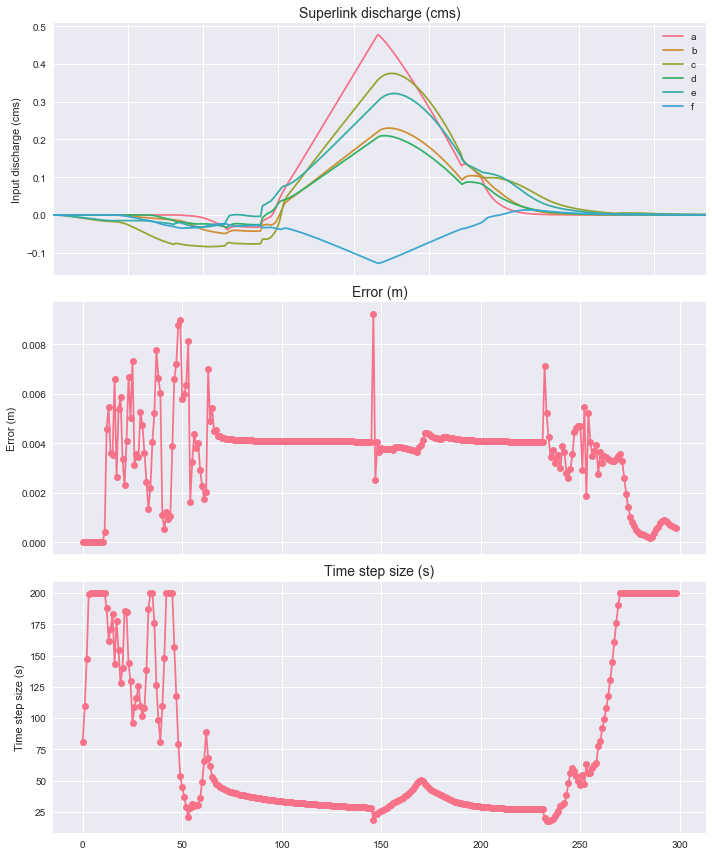

In [5]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl', 8)
%matplotlib inline

# Instantiate plot
fig, ax = plt.subplots(3, figsize=(10, 12))

# Compute average discharge in superlinks
simulation.states.Q_k = (simulation.states._Q_uk + simulation.states._Q_dk) / 2
errs = np.asarray(errs)
dts = np.asarray(dts)

# Plot results
simulation.states.Q_k.plot(ax=ax[0], title='Superlink discharge (cms)')
ax[1].plot(errs, marker='o')
ax[2].plot(dts, marker='o')
ax[1].set_title('Error (m)')
ax[2].set_title('Time step size (s)')

# Configure plots
ax[0].set_ylabel('Input discharge (cms)')
ax[1].set_ylabel('Error (m)')
ax[2].set_ylabel('Time step size (s)')
ax[0].title.set_size(14)
ax[1].title.set_size(14)
ax[2].title.set_size(14)
ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])
plt.tight_layout()